In [1]:
"""
-*- coding: utf-8 -*- Created on Fri 21 2020
@author: Thiago Pinho
@colaborators: Thiago Russo, Emmanuel Perotto
"""


from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, plot_confusion_matrix
from sklearn.base import BaseEstimator, TransformerMixin
import spacy
from spacy.lang.pt import Portuguese
from spacy.lang.pt.stop_words import STOP_WORDS
from unidecode import unidecode
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer
from string import punctuation
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from preprocessing import generate_freq_dist_plot, generate_wordcloud

## Constants
For better code management, the constants used in this notebook will be listed bellow.

In [2]:
VECTOR_MODEL_NAME = "pt_core_news_sm"
RELATIVE_PATH_TO_FOLDER = "./assets/datasets/ribon/"
DATA_FILENAME = "feeds_label"
NLP_SPACY = spacy.load(VECTOR_MODEL_NAME)
TARGET_VARIABLE = "LABEL_TRAIN"
POSSIBLE_TEXT_VARIABLES = ["CONTENT", "TITLE"]

## Load raw data and start to treat the it's structure
We'll have a first look at the raw data and after analysing it's structure we can fix missing values(By dropping or artificially inserting then). We can encode or adjust categorical data if needed, fix column names and also drop unnused colummns.

In [3]:
"""  load the dataset """
relative_path_file = RELATIVE_PATH_TO_FOLDER + DATA_FILENAME + ".csv"
df_ribon_news = pd.read_csv(relative_path_file)
print(df_ribon_news.info())
print()
print(df_ribon_news['Label_Train'].unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 888 entries, 0 to 887
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           888 non-null    int64 
 1   pick_count   888 non-null    int64 
 2   content      886 non-null    object
 3   title        888 non-null    object
 4   Label_Train  888 non-null    object
dtypes: int64(2), object(3)
memory usage: 34.8+ KB
None

['Animais' 'Solidariedade' 'Familia' 'Criancas' 'Proposito' 'Diversidade'
 'Educacao' 'Ecologia' 'Saude' 'Idosos' 'Ciencia' 'Celebracao' 'Etnias'
 'Esporte' 'Cultura' 'proposito' 'Empreendedorismo' 'empreendedorismo'
 'solidariedade' 'diversidade' 'celebracao' 'ecologia' 'etnias' 'ciencia'
 'saude' 'cultura' 'educacao' 'criancas']


### Results
Based on the previous step it's possible to notice two things:

1) First is that the column labels are not all uppercase or lowercase. 

2) The categories avaiable to classify are not all in the same case either which could lead to later confunsion on the real number of categories the model should classify.

So we will fix by making: 

1) All **column names** will be **uppercase**

2) All **target categories** will also be **uppercase**

In [4]:
"""  Preprocessing the dataset names and values """
df_ribon_news.columns = map(lambda x: str(x).upper(), df_ribon_news.columns)
""" Converting all labels in TARGET_VARIABLE to uppercase """
df_ribon_news[TARGET_VARIABLE] = df_ribon_news[TARGET_VARIABLE].str.upper()
print("Column names are now: ", df_ribon_news.columns.to_list())
print()
print(TARGET_VARIABLE + " categories are now: ", df_ribon_news[TARGET_VARIABLE].unique())

Column names are now:  ['ID', 'PICK_COUNT', 'CONTENT', 'TITLE', 'LABEL_TRAIN']

LABEL_TRAIN categories are now:  ['ANIMAIS' 'SOLIDARIEDADE' 'FAMILIA' 'CRIANCAS' 'PROPOSITO' 'DIVERSIDADE'
 'EDUCACAO' 'ECOLOGIA' 'SAUDE' 'IDOSOS' 'CIENCIA' 'CELEBRACAO' 'ETNIAS'
 'ESPORTE' 'CULTURA' 'EMPREENDEDORISMO']


### Storing partial progress
One of the advantages of jupyter notebook is the possibility of only repeating parts of the code when there is need for it. So let's store our partial progress for more stability and less rework.

In [5]:
"""  Let"s store the data """
excel_filename = RELATIVE_PATH_TO_FOLDER + DATA_FILENAME + "_treated.xlsx"

In [6]:
"""  Convert the dataframe to an xlsx file """
df_ribon_news.to_excel(excel_filename)

print("Stored tread dataset on ", excel_filename)

Stored tread dataset on  ./assets/datasets/ribon/feeds_label_treated.xlsx


## Load and analyse treated data
Now we have treated some structural characteristics of the data and some details, let's analyse the data.

In [7]:
"""  Load the data for stability """
df_ribon_news_treated = pd.read_excel(excel_filename, index_col=0)
print(df_ribon_news_treated.head())

   ID  PICK_COUNT                                            CONTENT  \
0  11           0  A forte ligação dos cães com o ser humano desp...   
1  12           0  Os chamados muros da gentileza estão promovend...   
2   9           0  Alguns de nós sabem a sorte que é ter um irmão...   
3   6           0               Temos muito o que aprender com elas.   
4   1           0  Esqueça o que te disseram sobre a zona de conf...   

                                               TITLE    LABEL_TRAIN  
0  Há mais de 10 anos, dupla de cães 🐶 acompanha ...        ANIMAIS  
1  Muros da gentileza ajudam desabrigados e famíl...  SOLIDARIEDADE  
2  20 fotos maravilhosas mostrando a alegria de t...        FAMILIA  
3  13 razões pelas quais crianças são bem mais es...       CRIANCAS  
4  Ex-executiva fala sobre vida sem propósito - I...      PROPOSITO  


### Label distribution, oversampling and undersampling
One important step is to analyse how the target categories are distributed. That's useful so we can better partition our data, maybe apply some over or undersampling if it's necessary.

Mean number of samples for the target variable is:  55.5
Standard deviation number of samples for the target variable is:  32.54125586595166


ECOLOGIA                     129 Warning         SOLIDARIEDADE                94 Warning   
PROPOSITO                     86 Okay            CULTURA                      79 Okay      
DIVERSIDADE                   72 Okay            ANIMAIS                      67 Okay      
EDUCACAO                      66 Okay            ETNIAS                       65 Okay      
CELEBRACAO                    56 Okay            ESPORTE                      34 Okay      
EMPREENDEDORISMO              32 Okay            CIENCIA                      31 Okay      
SAUDE                         24 Okay            FAMILIA                      19 Warning   
CRIANCAS                      19 Warning         IDOSOS                       15 Warning   



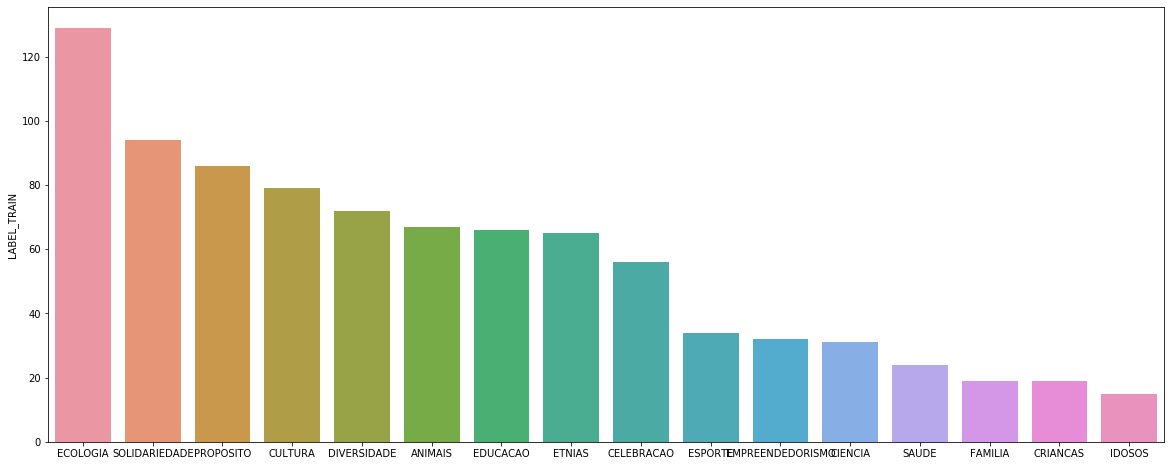

In [8]:
"""  Let"s see how the labels are distributed """
data_labels_count = df_ribon_news_treated[TARGET_VARIABLE].value_counts()
data_labels = data_labels_count.index
average_samples_per_label = data_labels_count.mean()
standard_deviation_for_labels = data_labels_count.std()
print(
    "Mean number of samples for the target variable is: ",
    average_samples_per_label)
print(
    "Standard deviation number of samples for the target variable is: ",
    standard_deviation_for_labels)

''' Numerical analysis
    One way to analyse the frequency of certain labels is to notice with
    they're too afar from the other labels frequencies average. Let's use
    standard deviation to check it'''
def is_it_further_than_std_deviations( value ):
    is_too_much = value > average_samples_per_label + standard_deviation_for_labels
    is_too_little = value < average_samples_per_label - standard_deviation_for_labels
    if is_too_much or is_too_little:
        message = "Warning"
    else:
        message = "Okay"

    return message

for i in tqdm(range(0, len(data_labels), 2)):
    even_indexed_label = data_labels[i]
    odd_indexed_label = data_labels[i+1]

    print("{0:20}  {1:10} {2:15} {3:20} {4:10} {5:10}".format(
        even_indexed_label, data_labels_count[even_indexed_label], is_it_further_than_std_deviations(data_labels_count[even_indexed_label]),
        odd_indexed_label, data_labels_count[odd_indexed_label], is_it_further_than_std_deviations(data_labels_count[odd_indexed_label])))

''' Visual plotting'''
fig = plt.figure(figsize=(20, 8))
sns.barplot(
    x=data_labels_count.index,
    y=data_labels_count)
plt.show()

### Results

Based on the previous step, we can see the categories **ECOLOGIA** and **SOLIDARIEDADE** have **more than the average added by the standard deviation** which can cause the model to overly recognise those labels patterns and make then too sensitive for those. 

On other hand we have the categories **FAMILIA**, **CRIANCAS** and **IDOSOS** with **less than the average subtracted by the standard deviation** which can make the model too specific for those and hardly classify as it.

Let's oversample the least common labels by grouping then. When our pipeline is finely tunned we can use the grouped labels as input for another pipeline trainned only to discern among those.
And also undersample the most common labels by ramdonly select less samples.


Let's check the labels found: 
Underpresented labels:  ['FAMILIA', 'CRIANCAS', 'IDOSOS']
Overrepresented labels:  ['ECOLOGIA', 'SOLIDARIEDADE']
Unchanged Labels:  ['CELEBRACAO', 'PROPOSITO', 'SAUDE', 'CIENCIA', 'CULTURA', 'EMPREENDEDORISMO', 'ANIMAIS', 'ESPORTE', 'EDUCACAO', 'DIVERSIDADE', 'ETNIAS']
SOLIDARIEDADE       88
ECOLOGIA            88
PROPOSITO           86
CULTURA             79
DIVERSIDADE         72
ANIMAIS             67
EDUCACAO            66
ETNIAS              65
CELEBRACAO          56
SCARCE_GROUP        53
ESPORTE             34
EMPREENDEDORISMO    32
CIENCIA             31
SAUDE               24
Name: LABEL_TRAIN, dtype: int64


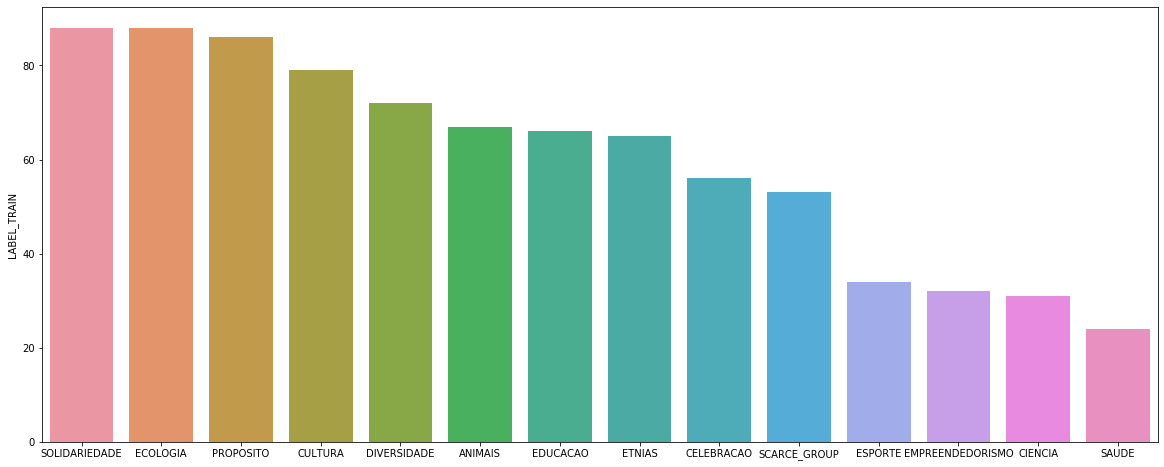

In [58]:
''' Let's create another dataframe and find which samples will be and how they'll be part of it'''
data_labels_count = df_ribon_news_treated[TARGET_VARIABLE].value_counts()
data_labels = data_labels_count.index
under_represented_labels = []
over_represented_labels = []
for label in tqdm(data_labels):
    if data_labels_count[label] < average_samples_per_label - standard_deviation_for_labels:
        under_represented_labels.append(label)
    elif data_labels_count[label] > average_samples_per_label + standard_deviation_for_labels:
        over_represented_labels.append(label)

unchanged_labels = list(set(data_labels) - set(under_represented_labels) - set(over_represented_labels))

print("Let's check the labels found: ")
print("Underpresented labels: ", under_represented_labels)
print("Overrepresented labels: ", over_represented_labels)
print("Unchanged Labels: ", unchanged_labels)

df_ribon_news_grouped = pd.DataFrame(columns=df_ribon_news_treated.columns)
for label in unchanged_labels:
    unchanged_rows = df_ribon_news_treated[df_ribon_news_treated[TARGET_VARIABLE] == label]
    df_ribon_news_grouped = df_ribon_news_grouped.append(unchanged_rows)

''' Now we have found which ones are under represented we'll add them to the new
    DataFrame and then change the under represented label to SCARCE_GROUP '''
for label in under_represented_labels:
    under_represented_rows = df_ribon_news_treated[df_ribon_news_treated[TARGET_VARIABLE] == label]
    df_ribon_news_grouped = df_ribon_news_grouped.append(under_represented_rows)

GROUP_TARGET_LABEL = 'SCARCE_GROUP'
df_ribon_news_grouped = df_ribon_news_grouped.replace(
    {TARGET_VARIABLE: under_represented_labels}, GROUP_TARGET_LABEL)

""" For the over represented, we'll select some of the samples."""
for label in over_represented_labels:
    over_represented_rows = df_ribon_news_treated[
        df_ribon_news_treated[TARGET_VARIABLE] == label].sample(int(average_samples_per_label + standard_deviation_for_labels))
    df_ribon_news_grouped = df_ribon_news_grouped.append(over_represented_rows)

print(df_ribon_news_grouped[TARGET_VARIABLE].value_counts())

"""  Let"s see how the labels are distributed """
data_labels_count = df_ribon_news_grouped[TARGET_VARIABLE].value_counts()
data_labels = data_labels_count.index
fig = plt.figure(figsize=(20, 8))
sns.barplot(
    x=data_labels_count.index,
    y=data_labels_count)
plt.show()

### Storing partial progress

In [111]:
excel_filename = RELATIVE_PATH_TO_FOLDER + DATA_FILENAME +\
    "_treated_grouped.xlsx"

In [112]:
"""  Let"s store the  data """
df_ribon_news_grouped.to_excel(excel_filename)

## Data Partition
Now we have treated the data structure and sampling problems. Let's drop unwanted columns.

In [113]:
"""  We then load the data for stability """
df_data = pd.read_excel(excel_filename, index_col=0)
print(df_data.head())

    ID  PICK_COUNT                                            CONTENT  \
53  57           0  Vai,Brasil! Nos dias 23 a 30 de julho, acontec...   
66  69           0  Um aluno brasileiro de 18 anos ganho um prêmio...   
75  78           0  O brasileiro Luiz Gabriel Tiago é um dos indic...   
85  89           0  Planejando uma viagem ao exterior? O primeiro ...   
87  91           0  Um ex-usuário de drogas, que perdeu a própria ...   

                                                TITLE LABEL_TRAIN  
53  Brasileiros ganham a Olimpíada Internacional d...  CELEBRACAO  
66  Aluno cria máquina para pessoas em coma “falar...  CELEBRACAO  
75  Conheça o brasileiro indicado ao Prêmio Nobel ...  CELEBRACAO  
85  Brasileiros podem entrar em mais de 100 países...  CELEBRACAO  
87  Ex-dependente, morador de albergue, passa em 3...  CELEBRACAO  


In [114]:
""" As we have two possible text_variables, let's choose one for first analysis """
text_variable = POSSIBLE_TEXT_VARIABLES[0]
""" Dropping unwanted columns """
df_data = df_data[ [text_variable] + [TARGET_VARIABLE]]
print(df_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 841 entries, 53 to 167
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   CONTENT      839 non-null    object
 1   LABEL_TRAIN  841 non-null    object
dtypes: object(2)
memory usage: 19.7+ KB
None


### Dealing with missing values
As there are some samples without content, they'll not be useful to train or to validate the model. 
Hapilly they're not many so let's drop them.

In [115]:
df_data = df_data.dropna()
print(df_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 839 entries, 53 to 167
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   CONTENT      839 non-null    object
 1   LABEL_TRAIN  839 non-null    object
dtypes: object(2)
memory usage: 19.7+ KB
None


## Text Filter(Preprocessing)

Before we train the model, it's necessary to tokenize words, find their lemmas and discard some words that could mislead the model.

Let's take a first look at the text variable.

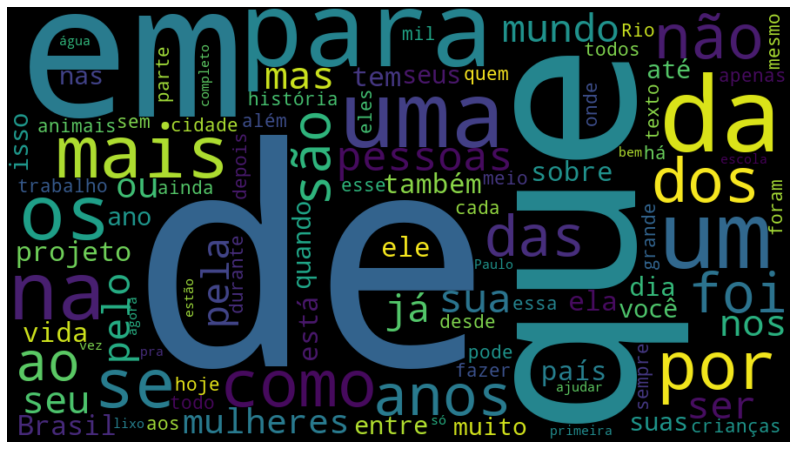

,       4926
de      3835
.       3008
a       2263
e       2250
o       1748
que     1727
do      1212
em      1146
da      1119
para    1085
um       862
uma      821
com      740
é        701
no       676
na       613
mais     503
os       495
as       414
A        413
se       395
por      390
como     385
O        377
dtype: int64


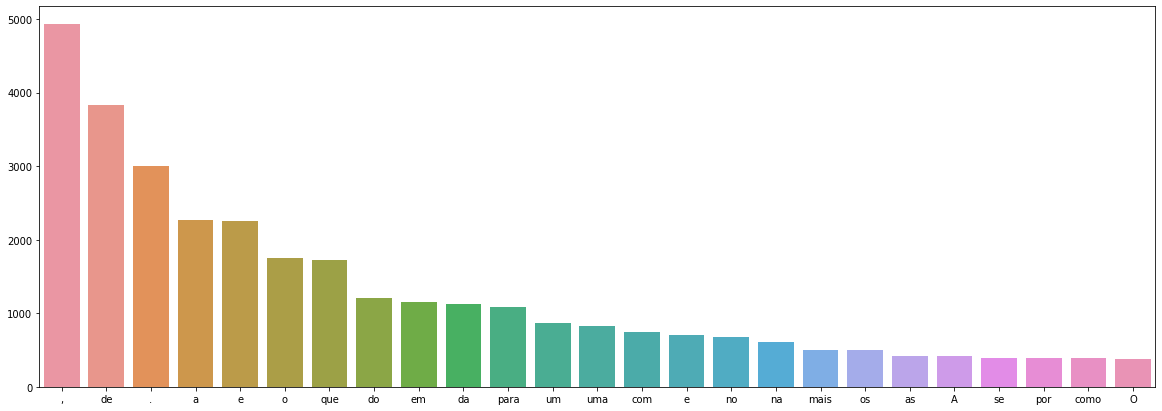

In [116]:
raw_text_column = df_data[text_variable]
generate_wordcloud(raw_text_column)
print(generate_freq_dist_plot(raw_text_column))

### Symbols and stopwords

As we can see, we have a lot of tokens from text variable being symbols or words that don't have by themselves much meaning. Let's fix that.
We can also strip trailing spaces and remove multiple spaces.

In [117]:
stopwords_set = set(STOP_WORDS).union(set(stopwords.words('portuguese')))
stopword_pattern = r'\b(?:{})\b'.format(r'|'.join(stopwords_set))
symbols_pattern = '[^\w\s]'
space_pattern = r'\s{2,}'
print("This is the stopword set: ", stopword_pattern)
print()
print("This is the symbols pattern: ", symbols_pattern)
print("This is the space pattern:", space_pattern)

This is the stopword set:  \b(?:demais|fez|me|quando|momento|quinta|então|essa|nas|teu|naquela|nove|têm|dezoito|tiver|breve|vossos|havemos|devem|debaixo|parece|tudo|mesmo|estará|quatro|atrás|nunca|onze|faço|esta|tente|tal|houveríamos|fará|maioria|são|segunda|tivera|iniciar|fazia|próprio|todo|dele|dá|toda|dizem|tivesse|quer|na|estado|ambas|daquele|esteja|treze|fazer|apenas|seja|posso|sois|isto|portanto|dar|obrigado|usar|nesse|contra|oito|houver|porque|quanto|assim|quero|tinha|põem|como|desta|algo|umas|sétima|aqui|alguns|último|povo|teus|hei|nos|deste|quais|próximo|lugar|dessa|dez|nossas|haja|isso|sei|pelo|ambos|lá|também|conselho|pois|põe|somente|suas|aos|houveremos|pouca|bom|aquela|nosso|sua|forem|tenho|sabe|mais|houvermos|houverão|só|caminho|tipo|estávamos|quarta|antes|ele|quinto|fazem|tivermos|vêm|vós|contudo|hajam|houveria|cima|pelos|local|à|no|menor|uma|sim|vos|teriam|dela|qualquer|cada|estivesse|tarde|dois|se|ver|estiveste|estão|comprido|vindo|apoia|outras|minhas|obrigada|porquê|t

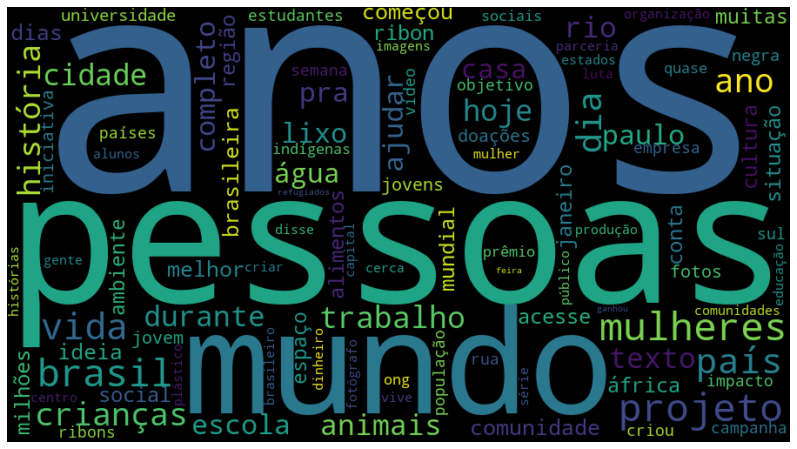

anos        312
pessoas     222
mundo       192
mulheres    152
projeto     149
brasil      145
vida        131
país        123
dia         117
ano         106
crianças    101
história     94
trabalho     87
hoje         80
cidade       78
animais      74
durante      72
texto        70
rio          70
completo     67
pra          66
lixo         64
escola       64
ajudar       64
paulo        63
dtype: int64


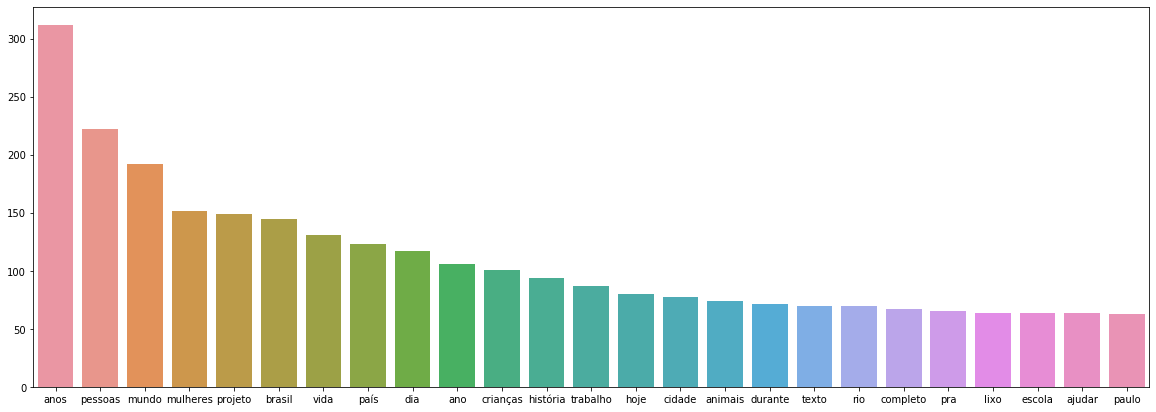

In [118]:
''' Processing text on caracteres level'''
df_data['PREPROCESSED_TEXT'] = df_data[text_variable].str.lower()
df_data['PREPROCESSED_TEXT'] = df_data['PREPROCESSED_TEXT'].str.replace(
    stopword_pattern, "")
df_data['PREPROCESSED_TEXT'] = df_data['PREPROCESSED_TEXT'].str.replace(
    symbols_pattern, "")
df_data['PREPROCESSED_TEXT'] = df_data['PREPROCESSED_TEXT'].str.replace(
    space_pattern, " ")
df_data['PREPROCESSED_TEXT'] = df_data['PREPROCESSED_TEXT'].str.strip()
generate_wordcloud(df_data['PREPROCESSED_TEXT'])
print(generate_freq_dist_plot(df_data['PREPROCESSED_TEXT']))

### Results
Now the most common words are way more expressive.

### Lemmatizing and stemming


Pipe already present.
['tagger', 'sentencizer', 'parser', 'ner']


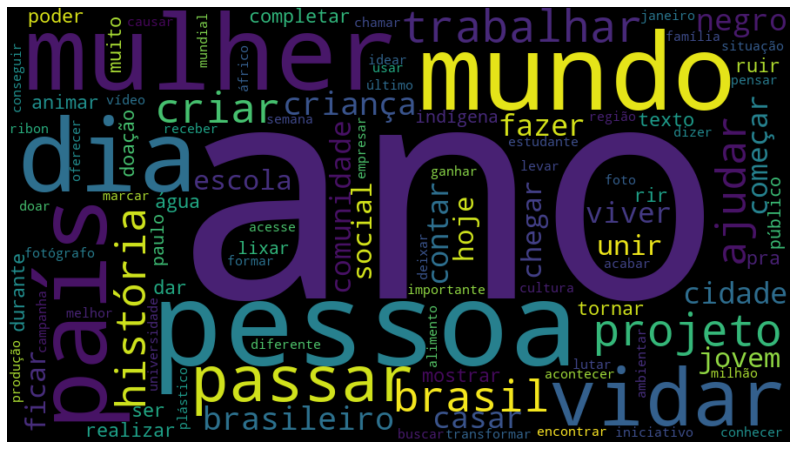

ano           418
pessoa        241
mundo         192
mulher        185
dia           174
país          162
passar        152
vidar         152
trabalhar     151
projeto       149
brasil        145
criar         137
ajudar        129
história      128
brasileiro    122
criança       121
casar         106
negro         103
contar        100
cidade         98
fazer          97
começar        94
viver          93
comunidade     92
chegar         87
dtype: int64


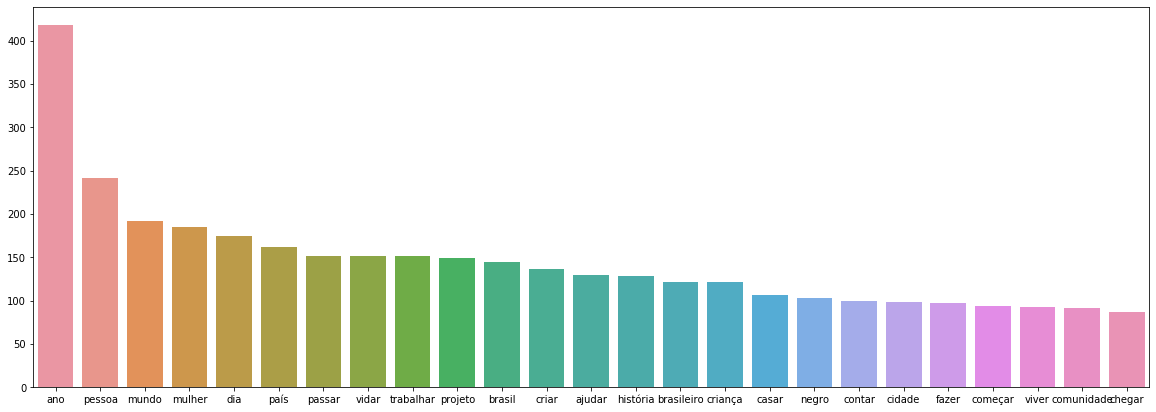

In [120]:
preprocessed_text_data = df_data['PREPROCESSED_TEXT'].to_list()
''' Not all variables are being undestood as strings so we have to force it'''

sentencizer = NLP_SPACY.create_pipe('sentencizer')
''' Create the pipeline 'sentencizer' component '''

try:
    ''' We then add the component to the pipeline if we hadn't done before '''
    NLP_SPACY.add_pipe(sentencizer, before='parser')
except ValueError:
    print("Pipe already present.")

print(NLP_SPACY.pipe_names)

tokenized_data = []
semantics_data = []
lemmatized_doc = []
for row in tqdm(preprocessed_text_data):
    doc = NLP_SPACY(row)
    tokenized_data.append(doc)
    lemmatized_doc.append(
        " ".join(
            [word.lemma_ for word in doc]))

df_data['LEMMATIZED_DOC'] = lemmatized_doc

generate_wordcloud(df_data['LEMMATIZED_DOC'])
print(generate_freq_dist_plot(df_data['LEMMATIZED_DOC']))

### Entity Recognition
Some parts of speech may mislead the model associating classes to certain entities that are not really related to the categories.
The NER model(spacy portuguese) we are using uses the following labels:

| TYPE | DESCRIPTION |
|------|-------------------------------------------------------------------------------------------------------------------------------------------|
| PER | Named person or family. |
| LOC | Name of politically or geographically defined location (cities, provinces, countries, international regions, bodies of water, mountains). |
| ORG | Named corporate, governmental, or other organizational entity. |
| MISC | Miscellaneous entities, e.g. events, nationalities, products or works of art. |

Let's take a look at the named persons or families

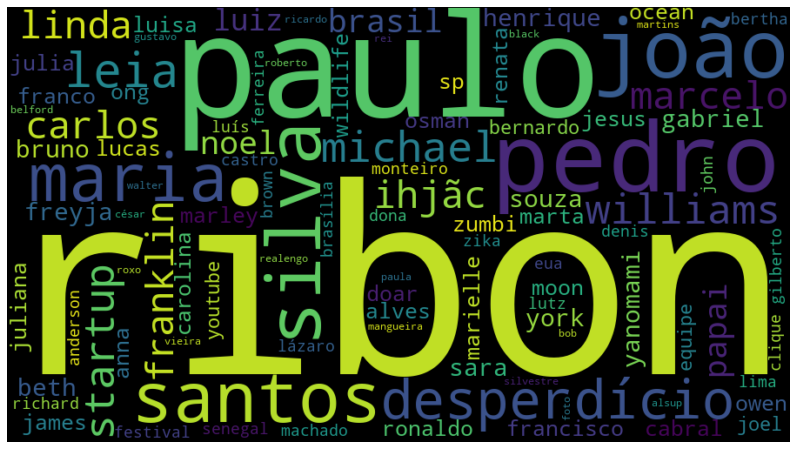

ribon          32
paulo          22
joão           12
pedro          12
santos         10
silva          10
maria           9
desperdício     9
startup         7
williams        7
michael         7
leia            7
carlos          6
linda           6
papai           6
brasil          6
marcelo         6
noel            6
ihjãc           6
franklin        6
luiz            5
yanomami        5
freyja          5
henrique        5
sara            5
dtype: int64


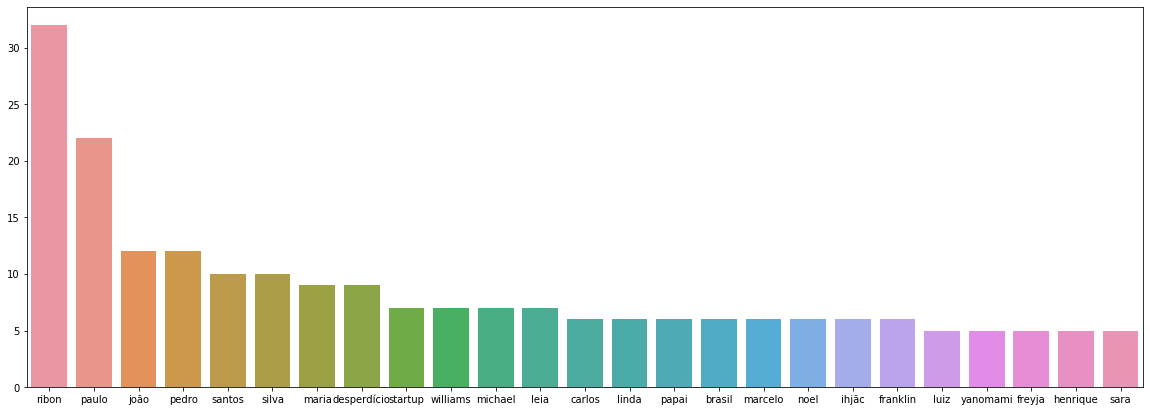

In [121]:
''' First we take a look at the found entities'''
entities_lists = []

for docs in tokenized_data:
    entities_text = ""
    for entity in docs.ents:
        if entity.label_ == "PER":
            entities_text += " " + entity.text
    entities_text = entities_text.strip()
    entities_lists.append(entities_text)
            
df_data['ENTITIES'] = entities_lists
generate_wordcloud(df_data['ENTITIES'])
print(generate_freq_dist_plot(df_data['ENTITIES']))

### Removing Entities

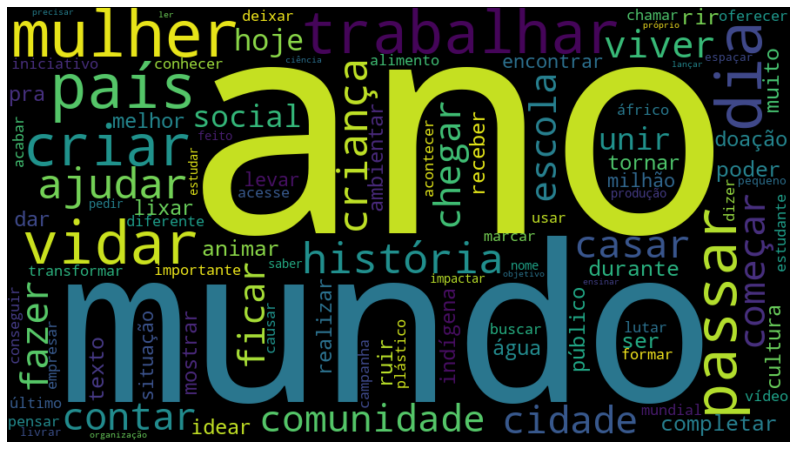

ano           418
mundo         192
mulher        185
dia           174
país          162
passar        152
vidar         152
trabalhar     151
criar         137
ajudar        129
história      128
criança       121
casar         106
contar        100
cidade         98
fazer          97
começar        94
viver          93
comunidade     92
chegar         87
ficar          85
escola         85
social         84
unir           84
hoje           80
dtype: int64


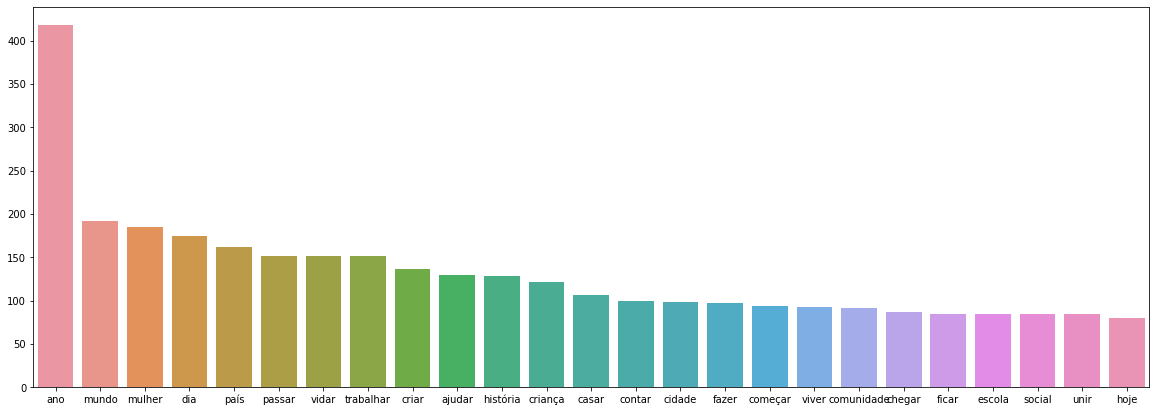

In [123]:
entities_set = set()
entities_set = set([ word for word_list in list(map(list, df_data['ENTITIES'].str.split(" ")))
                            for word in word_list ])
entities_set.remove("")
entities_pattern = r'\b(?:{})\b'.format('|'.join(entities_set)) 

''' Processing text on entity level'''
df_data['PROCESSED_DOC'] = df_data['LEMMATIZED_DOC'].str.replace(entities_pattern, "")
generate_wordcloud(df_data['PROCESSED_DOC'])
print(generate_freq_dist_plot(df_data['PROCESSED_DOC']))

### POS Analysis
Let's take a look in the parts of speech presents in the dataset

PROPN    10296
NOUN      9443
VERB      8615
ADJ       6533
NUM       1026
ADV        846
DET        531
SYM        495
ADP        320
AUX        307
X           62
PRON        58
SPACE       39
PUNCT       14
CCONJ       12
SCONJ       10
dtype: int64


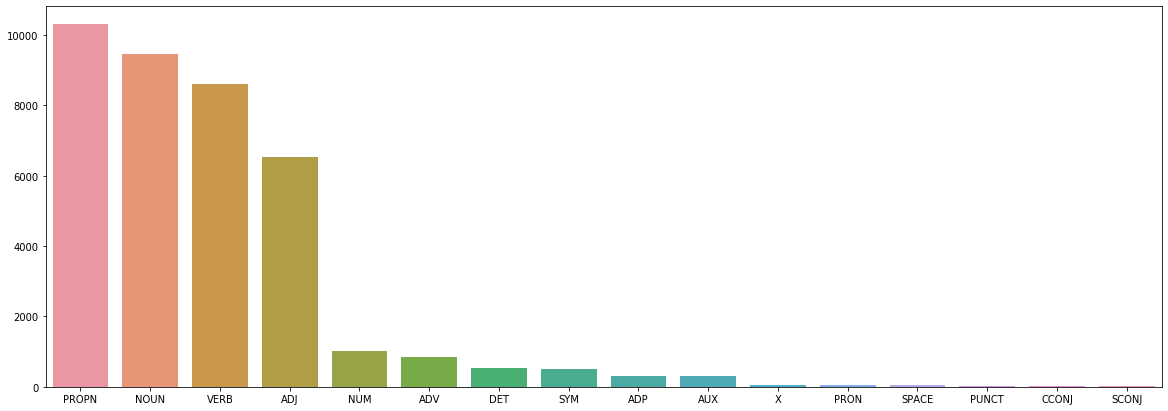

In [125]:
semantics_data = []
for doc in tokenized_data:
    semantics_data.append(" ".join([word.pos_ for word in doc]))

df_data['SEMANTICS'] = semantics_data
print(generate_freq_dist_plot(df_data['SEMANTICS']))

### Removing POS

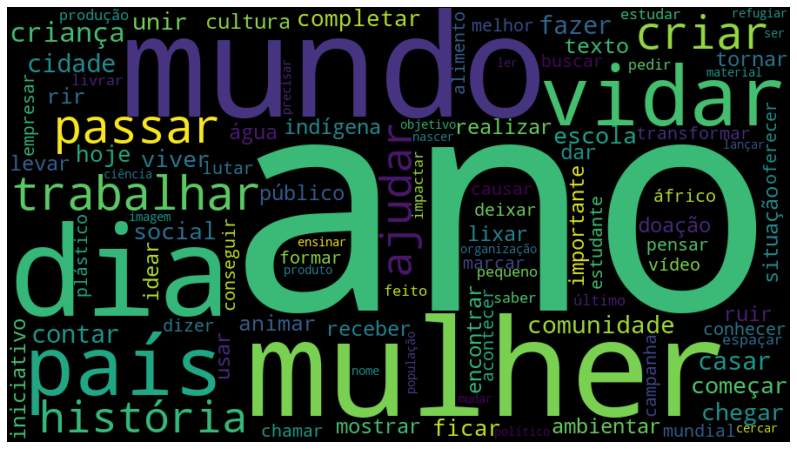

ano           194
mundo         192
mulher        185
dia           159
vidar         152
país          151
trabalhar     150
passar        148
criar         137
ajudar        128
história      127
criança       121
contar        100
cidade         98
casar          98
fazer          96
comunidade     92
viver          87
começar        85
escola         85
chegar         84
social         84
unir           84
hoje           80
ficar          80
dtype: int64


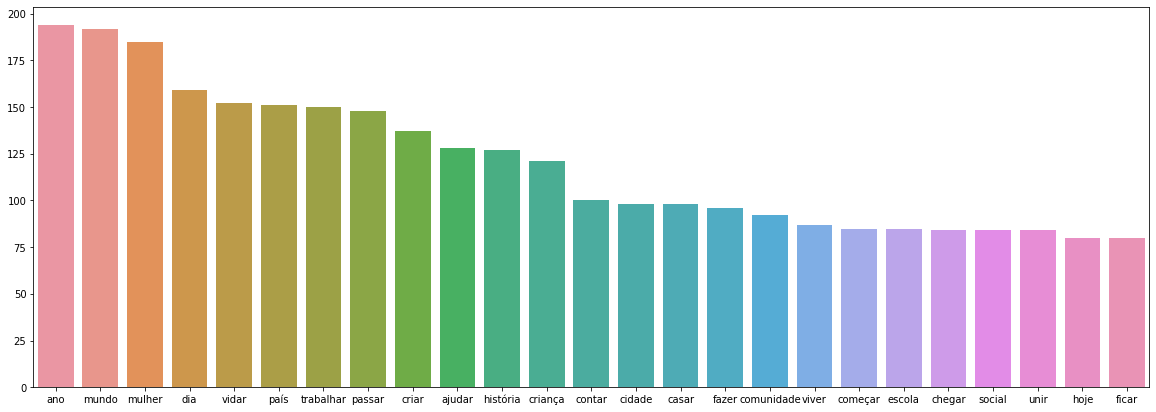

In [187]:
ALLOWED_POS = set(["PROPN", "NOUN", "ADV", "ADJ", "VERB"])

processed_doc = []
for doc in tokenized_data:
    processed_doc.append(
        " ".join(
            [word.lemma_ if str(word.pos_) in ALLOWED_POS else "" for word in doc]))

df_data['PROCESSED_DOC'] = processed_doc
''' Processing text on entity level again '''
df_data['PROCESSED_DOC'] = df_data['PROCESSED_DOC'].str.replace(entities_pattern, "")
generate_wordcloud(df_data['PROCESSED_DOC'])
print(generate_freq_dist_plot(df_data['PROCESSED_DOC']))

### Storing partial progress

In [188]:
"""  Let"s store the data """
excel_filename = RELATIVE_PATH_TO_FOLDER + DATA_FILENAME +\
    "_processed_data.xlsx"

In [189]:
df_data.to_excel(excel_filename)

 ## Text Parser(Counting and vectorizing)
 Now we have clear tokens we can measure how much they affect the outcome prediction and how many of them exist in each sample.

In [190]:
"""  We then load the data for stability """
df_processed_data = pd.read_excel(excel_filename, index_col=0)
print(df_processed_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 839 entries, 53 to 167
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   CONTENT            839 non-null    object
 1   LABEL_TRAIN        839 non-null    object
 2   PREPROCESSED_TEXT  839 non-null    object
 3   LEMMATIZED_DOC     839 non-null    object
 4   ENTITIES           514 non-null    object
 5   PROCESSED_DOC      839 non-null    object
 6   SEMANTICS          839 non-null    object
dtypes: object(7)
memory usage: 52.4+ KB
None


### Dealing with missing values
As there are some samples without content, they'll not be useful to train or to validate the model. 
Hapilly they're not many so let's drop them.

In [191]:
df_processed_data = df_processed_data.drop('ENTITIES', 1).dropna()
print(df_processed_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 839 entries, 53 to 167
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   CONTENT            839 non-null    object
 1   LABEL_TRAIN        839 non-null    object
 2   PREPROCESSED_TEXT  839 non-null    object
 3   LEMMATIZED_DOC     839 non-null    object
 4   PROCESSED_DOC      839 non-null    object
 5   SEMANTICS          839 non-null    object
dtypes: object(6)
memory usage: 45.9+ KB
None


In [192]:
''' Best parameter using GridSearch (CV score=0.535):
{'clf__alpha': 1e-05, 'clf__max_iter': 80, 'clf__penalty': 'l2', 'tfidf__norm': 'l1',
'tfidf__use_idf': True, 'vect__max_df': 0.5, 'vect__max_features': None, 'vect__ngram_range': (1, 2)}
'''
''' Text Parser
    This part is responsible to give weights to important tokens and remove
    weight for unwanted ones or those who can be misguiding.
    - Frequency Counter
    - Id-IdF Counter
'''
count_vectorizer = CountVectorizer(
    max_features=None, min_df=0, max_df=0.5, ngram_range=(1, 2))
tfidf_transformer = TfidfTransformer(norm='l1', use_idf='True')

''' Let's transform the lemmatized documents into count vectors '''
count_vectors = count_vectorizer.fit_transform(
    df_processed_data['PROCESSED_DOC'])

''' Then use those count vectors to generate frequency vectors '''
frequency_vectors = tfidf_transformer.fit_transform(count_vectors)

print(count_vectors[0])
print(frequency_vectors[0])

  (0, 139)	1
  (0, 140)	1
  (0, 174)	1
  (0, 175)	1
  (0, 613)	1
  (0, 616)	1
  (0, 6900)	1
  (0, 6950)	1
  (0, 8100)	1
  (0, 8101)	1
  (0, 9795)	1
  (0, 9797)	1
  (0, 13731)	1
  (0, 13789)	1
  (0, 15105)	1
  (0, 18059)	1
  (0, 18062)	1
  (0, 19297)	1
  (0, 19304)	1
  (0, 19805)	1
  (0, 19807)	1
  (0, 21445)	1
  (0, 21446)	1
  (0, 22421)	1
  (0, 22424)	1
  (0, 23458)	2
  (0, 23514)	1
  (0, 23537)	1
  (0, 23658)	1
  (0, 23664)	1
  (0, 24748)	1
  (0, 24751)	1
  (0, 27729)	1
  (0, 27743)	1
  (0, 27743)	0.03378425594112455
  (0, 27729)	0.022277412660800418
  (0, 24751)	0.03378425594112455
  (0, 24748)	0.02713180863253645
  (0, 23664)	0.03378425594112455
  (0, 23658)	0.024801989473648495
  (0, 23537)	0.03378425594112455
  (0, 23514)	0.029387227442634337
  (0, 23458)	0.028036247254959328
  (0, 22424)	0.03378425594112455
  (0, 22421)	0.02851231618005679
  (0, 21446)	0.03378425594112455
  (0, 21445)	0.03183853983435084
  (0, 19807)	0.03378425594112455
  (0, 19805)	0.02560363631509447
  (0, 193

### Model Train and Cross-Validation

In [193]:
count_vectorizer = CountVectorizer(
    max_features=None, min_df=0, max_df=0.5, ngram_range=(1, 2))
tfidf_transformer = TfidfTransformer(norm='l1', use_idf='True')
clf = SGDClassifier(alpha=1e-05, max_iter=80, penalty='l2')

pipeline_simple = Pipeline([
    ('clf', clf)
])
pipeline = Pipeline([
    ('count_vectorizer', count_vectorizer),
    ('tfidf_transformer', tfidf_transformer),
    ('clf', clf)
])

''' Let's use cross validation to better evaluate models ''' 
scores = cross_val_score(
    pipeline_simple,
    frequency_vectors,
    df_processed_data[TARGET_VARIABLE], cv=10)
print("Mean accuracy for explicit pipeline: ", scores.mean())

scores = cross_val_score(
    pipeline,
    df_processed_data['PROCESSED_DOC'],
    df_processed_data[TARGET_VARIABLE], cv=10)
print("Mean accuracy for implicit pipeline: ", scores.mean())

Mean accuracy for explicit pipeline:  0.47081181870338495
Mean accuracy for implicit pipeline:  0.4720166379804934


### Evaluating the best model

In [194]:
''' Let's evaluate more deeply the best model '''
X_train, X_test, y_train, y_test = train_test_split(
    df_processed_data['PROCESSED_DOC'],
    df_processed_data[TARGET_VARIABLE],
    test_size=0.33, random_state=42)

pipeline = Pipeline([
    ('count_vectorizer', count_vectorizer),
    ('tfidf_transformer', tfidf_transformer),
    ('clf', clf)
])

train1 = X_train.tolist()
labelsTrain1 = y_train.tolist()
test1 = X_test.tolist()
labelsTest1 = y_test.tolist()
"""  train """
pipeline.fit(train1, labelsTrain1)
"""  test """
preds = pipeline.predict(test1)
print("accuracy:", accuracy_score(labelsTest1, preds))
print(
    classification_report(
        labelsTest1,
        preds,
        target_names=df_processed_data[TARGET_VARIABLE].unique()))

accuracy: 0.4620938628158845
                  precision    recall  f1-score   support

      CELEBRACAO       0.78      0.67      0.72        27
       PROPOSITO       0.67      0.21      0.32        19
           SAUDE       0.11      0.17      0.13         6
         CIENCIA       0.35      0.50      0.41        26
         CULTURA       0.40      0.27      0.32        22
EMPREENDEDORISMO       0.51      0.64      0.57        28
         ANIMAIS       0.57      0.62      0.59        26
         ESPORTE       0.33      0.27      0.30        11
        EDUCACAO       0.56      0.62      0.59         8
     DIVERSIDADE       0.32      0.48      0.38        21
          ETNIAS       0.76      0.46      0.57        35
    SCARCE_GROUP       0.25      0.20      0.22         5
        ECOLOGIA       0.23      0.23      0.23        13
   SOLIDARIEDADE       0.38      0.47      0.42        30

        accuracy                           0.46       277
       macro avg       0.44      0.41    

### Better visualising model classification

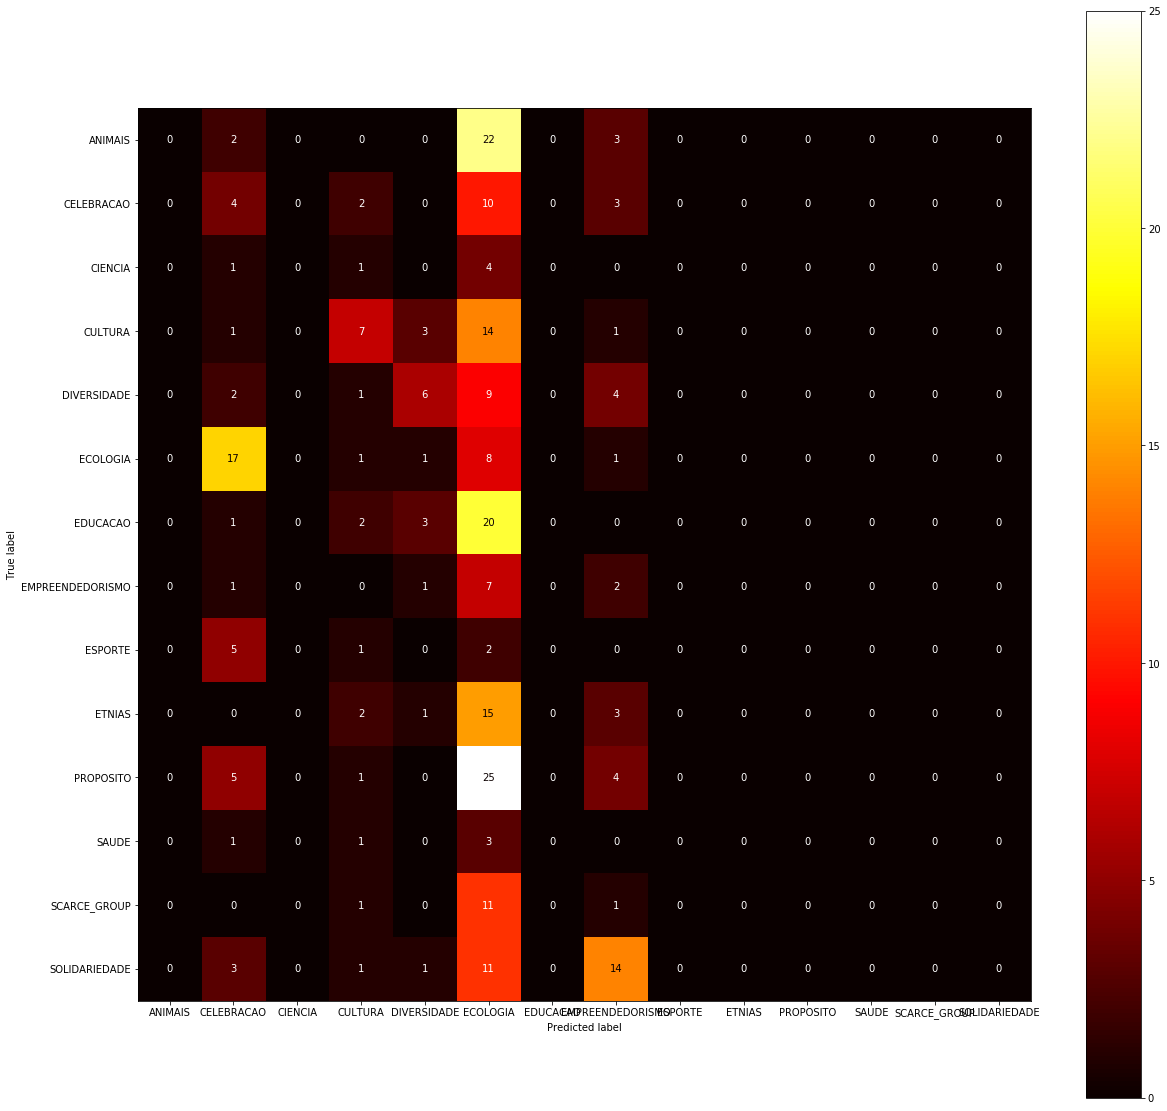

In [186]:
fig = plt.figure(figsize=(20, 20))
axes = plt.axes()

print(plot_confusion_matrix(pipeline, preds, labelsTest1, cmap='hot', ax=axes))

As we can see, we're having a terrible problem with the oversampled labels. Maybe undersampling them could improve the model perfomance